In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import scipy.stats as stats
import random as rd
import sys
import os

np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
CURRENT_DIRECTORY = os.path.dirname(os.path.realpath('__file__'))
DATASET_DIRECTORY = os.path.join(CURRENT_DIRECTORY,'temporal_networks_li', 'Processed_data')

datasets = ["Hospital", "copresence_LH10", "Hypertext2009"]
dataset_name = datasets[2]
filename = os.path.join(DATASET_DIRECTORY, f'{dataset_name}.csv')

In [6]:
column_names = ["source", "target", "Timestamp", "Time order"]
data = pd.read_csv(filename,names=column_names)

# Drop absolute time which is not important
data = data.drop(["Timestamp"], axis=1)
data = data.rename(columns={"source":"node1", "target":"node2", "Time order": "timestamp"})

# Replace node lables with contiguous numbers
nodes = set()
nodes.update(list(data["node1"]), list(data["node2"]))
nodes = sorted(list(nodes))
node_replacement = {}
for index, node in enumerate(nodes):
    node_replacement[node] = index+1

data["node1"] = data["node1"].replace(node_replacement)
data["node2"] = data["node2"].replace(node_replacement)
data = data.sort_values(by='timestamp')

In [7]:
print(data)

      node1  node2  timestamp
2952      1      2          1
2953      1      2          2
2954      1      2          3
2955      1      2          4
2956      1      2          5
...     ...    ...        ...
2707      1     12       5245
2950     12    112       5245
2951     12    112       5246
5750     15     88       5246
2708      1     12       5246

[20818 rows x 3 columns]


N: 113
T: 5246


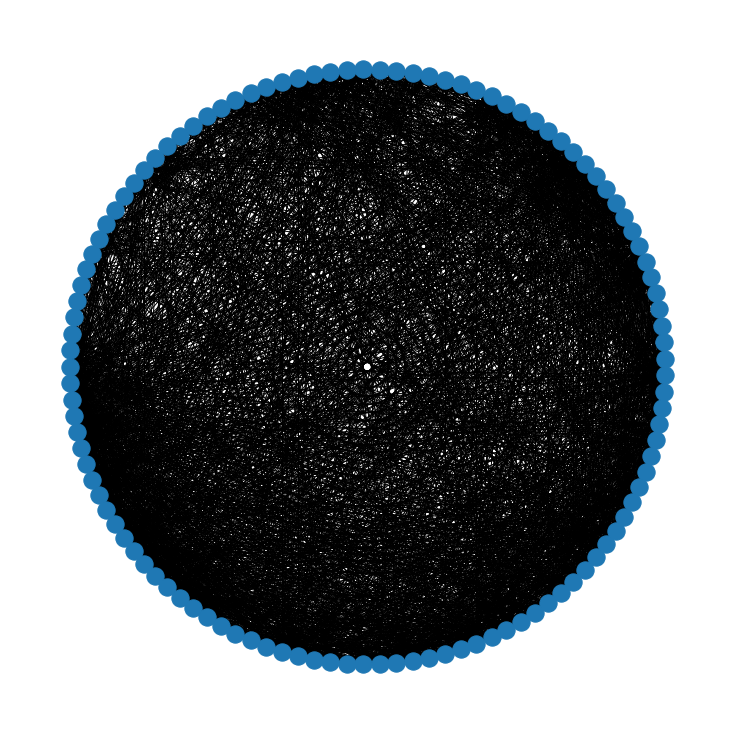

In [8]:
G = nx.from_pandas_edgelist(data, "node1", "node2", edge_attr=["timestamp"])

nx.draw_shell(G)
T=data.iloc[-1]["timestamp"]

print(f"N: {G.number_of_nodes()}")
print(f"T: {T}")

In [9]:
# Given a dataframe of temporal edges, returns the activation timestamps of each link in a dict
def link_time_series(original_df):
    link_ts = {}
    temporal_edge_list = original_df.to_records(index=False)
    for link in temporal_edge_list:
        node1, node2, timestamp = link
        # order of nodes does not matter for forzen set comparison
        link_nodes = frozenset((node1, node2))
        if link_nodes not in link_ts:
            link_ts[link_nodes] = [timestamp]
        else:
            link_ts[link_nodes].append(timestamp)
    return link_ts

# Given the link_time_series, builds a dataframe of temporal edges for use in other functions
def build_df(link_ts):
    temporal_edge_list = []
    for link_nodes, time_series in link_ts.items():
        temporal_edge_list += [(min(link_nodes), max(link_nodes), timestamp) for timestamp in time_series]
    df = pd.DataFrame(temporal_edge_list, columns=["node1", "node2", "timestamp"])
    df = df.sort_values(by=['timestamp'])
    df = df.reset_index(drop=True)
    return df

In [10]:
# Given an intial node N, a graph G and a list of timestamps temporal_edge_list
# simulates the spread of an infection starting from node N
def infection(N,G,temporal_edge_list):
    nx.set_node_attributes(G,False,"infected")
    G.nodes[N]["infected"] = True
    nodes_infection_time = {node:T for node in G.nodes}
    nodes_infection_time[N] = 0
    infected_nodes_over_time = [0 for i in range(T)]
    infected_nodes_over_time[0] = 1
    previous_timestamp = 0
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        if timestamp > previous_timestamp:
            newly_infected = []
        if G.nodes[node1]["infected"] and not G.nodes[node2]["infected"] and not node1 in newly_infected:
            G.nodes[node2]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
            nodes_infection_time[node2] = timestamp-1
            newly_infected.append(node2)
        elif G.nodes[node2]["infected"] and not G.nodes[node1]["infected"] and not node2 in newly_infected:
            G.nodes[node1]["infected"] = True
            infected_nodes_over_time[timestamp-1] += 1
            nodes_infection_time[node1] = timestamp-1
            newly_infected.append(node1)
        previous_timestamp = timestamp
    return np.cumsum(infected_nodes_over_time), nodes_infection_time

# Randomizations

1. G1 is obtained by reshuffling the time stamps among the contacts, without changing the topo- logical locations of the contacts. This randomization does not change the number of contacts between each node pair, only the timing is randomly changed, thus preserving the probability distribution of the topological distance of two randomly selected contacts.

2. G2 is obtained by iterating the step where two links are randomly selected from the aggregated network and their time series are swapped. This randomization does not change the distribution of the inter-event time of the activity of a random link.

3. G3 is obtained by swapping the activity time series of two randomly selected links but with the same total number of contacts. This randomization preserves the number of contacts per node pair, the distribution of the inter-event time of contacts between a node pair and the distribution of the topological distance of two randomly selected contacts.

The three randomized networks lead to the same unweighted aggregated network as the original network G .

In [11]:
def g1_randomize(original_df):
    g1_df = original_df.copy()
    g1_df["timestamp"] = np.random.permutation(g1_df["timestamp"].values)
    g1_df = g1_df.sort_values(by=['timestamp'])
    g1_df = g1_df.reset_index(drop=True)
    return g1_df

def g2_randomize(original_df, number_of_swaps):
    link_ts = link_time_series(original_df)
    # Swap any two time series
    for _ in range(number_of_swaps):
        link1 = rd.choice(list(link_ts.keys()))
        link2 = rd.choice(list(link_ts.keys()))
        link_ts[link1], link_ts[link2] = link_ts[link2], link_ts[link1]
    g2_df = build_df(link_ts)
    return g2_df

def g3_randomize(original_df, number_of_swaps):
    link_ts = link_time_series(original_df)
    grouped_link_ts = {}
    # Group links based on the number of activations
    for link_nodes, time_series in link_ts.items():
        n = len(time_series)
        if n in grouped_link_ts:
            grouped_link_ts[n].append(link_nodes)
        else:
            grouped_link_ts[n] = [link_nodes]
    # Remove links with less than 2 activations
    to_remove = []
    for n, links in grouped_link_ts.items():
        if (len(links)<2):
            to_remove.append(n)
    for n in to_remove:
        del grouped_link_ts[n]
    # Swap time series of links with equal activations
    for _ in range(number_of_swaps):
        candidate_links = rd.choice(list(grouped_link_ts.values()))
        link1 = rd.choice(candidate_links)
        link2 = rd.choice(candidate_links)
        link_ts[link1], link_ts[link2] = link_ts[link2], link_ts[link1]
    g3_df = build_df(link_ts)
    return g3_df

# Abstraction function to get different types of randomizations
def randomize(original_df, randomization = 1, number_of_swaps = 10000):
    if (randomization == 1):
        return g1_randomize(original_df)
    elif (randomization == 2):
        return g2_randomize(original_df, number_of_swaps)
    else:
        return g3_randomize(original_df, number_of_swaps)

# Influence types

1. Time taken to infect `N * node_fraction` nodes, with the given node infected at `t=0` (lower is better)
2. Percentage of nodes infected at `t = T * time_fraction`, with the given node infected at `t=0` (higher is better)
3. Average percentage of nodes infected in `t = T * time_fraction` after the given node is infected at some `t` (higher is better)

In [12]:
# Given a graph, edges dataframe, and the node fraction, returns the sorted values of the influence_1 of each node
def influence_1(G, edge_data, node_fraction = 0.3):
    n_star = int(node_fraction * G.number_of_nodes())
    total_num_infected_at_time_t = []

    for node in G.nodes:
        infected_nodes_over_time, nodes_infection_timestamp = infection(node, G, edge_data.to_records(index=False))
        total_num_infected_at_time_t.append(infected_nodes_over_time)
    
    time_for_n_star = []
    for node in total_num_infected_at_time_t:
        greater_than_n_star = list(i for i, val in enumerate(node) if val > n_star)
        time_for_n_star.append(greater_than_n_star[0]+1 if len(greater_than_n_star)>0 else T)

    influence_dict = {list(G.nodes)[i]:time_for_n_star[i] for i in range(len(time_for_n_star))}
    sorted_influence = {k: v for k, v in sorted(influence_dict.items(), key=lambda item: item[1],reverse=False)}
    return sorted_influence

In [13]:
# Given a graph, edges dataframe, and the time fraction, returns the sorted values of the influence_2 of each node
def influence_2(G, edge_data, time_fraction = 0.3):
    t_star = int(time_fraction * T)
    total_num_infected_at_time_t = []

    for node in G.nodes:
        infected_nodes_over_time, nodes_infection_timestamp = infection(node, G, edge_data.to_records(index=False))
        total_num_infected_at_time_t.append(infected_nodes_over_time)

    influence_at_t_star = [node[t_star]/G.number_of_nodes() for node in total_num_infected_at_time_t]
    influence_dict = {list(G.nodes)[i]:influence_at_t_star[i] for i in range(len(influence_at_t_star))}
    sorted_influence = {k: v for k, v in sorted(influence_dict.items(), key=lambda item: item[1],reverse=True)}
    return sorted_influence

In [14]:
# Given a graph, edges dataframe, and the time fraction, returns the sorted values of the influence_3 of each node
def influence_3(G, edge_data, time_fraction):
    t_delta = int(time_fraction * T)
    total_num_infected_at_time_t = []
    total_nodes_infection_timestamp = []
    for node in G.nodes:
        infected_nodes_over_time, nodes_infection_timestamp = infection(node, G, edge_data.to_records(index=False))
        total_num_infected_at_time_t.append(infected_nodes_over_time)
        total_nodes_infection_timestamp.append(nodes_infection_timestamp)

    nodes_influence = [0 for node in G.nodes]
    for seed_node_index in range(len(G.nodes)):
        num_infected = total_num_infected_at_time_t[seed_node_index]
        infection_timestamps = total_nodes_infection_timestamp[seed_node_index]
        
        for node_index in range(len(G.nodes)):
            node = list(G.nodes)[node_index]
            if (infection_timestamps[node]<T):
                spread_after_infection = num_infected[infection_timestamps[node]:(infection_timestamps[node]+t_delta)]
                nodes_influence[node_index] += (max(spread_after_infection) - min(spread_after_infection))
    
    nodes_influence = [x/(G.number_of_nodes()**2) for x in nodes_influence]
    
    influence_dict = {list(G.nodes)[i]:nodes_influence[i] for i in range(len(nodes_influence))}
    sorted_influence = {k: v for k, v in sorted(influence_dict.items(), key=lambda item: item[1],reverse=True)}
    return sorted_influence

In [15]:
# Abstraction function to get different types of influence defined
def get_influence(G, edge_data, influence_type = 1, node_fraction = 0.3, time_fraction = 0.3):
    if (influence_type==1):
        return influence_1(G, edge_data, node_fraction)
    elif (influence_type==2):
        return influence_2(G, edge_data, time_fraction)
    else:
        return influence_3(G, edge_data, time_fraction)

In [16]:
print(influence_2(G, data, 0.3))

{1: 0.8584070796460177, 2: 0.8584070796460177, 3: 0.8584070796460177, 4: 0.8584070796460177, 5: 0.8584070796460177, 6: 0.8584070796460177, 7: 0.8584070796460177, 8: 0.8584070796460177, 9: 0.8584070796460177, 10: 0.8584070796460177, 11: 0.8584070796460177, 12: 0.8584070796460177, 13: 0.8584070796460177, 14: 0.8584070796460177, 15: 0.8584070796460177, 16: 0.8584070796460177, 17: 0.8584070796460177, 19: 0.8584070796460177, 18: 0.8584070796460177, 20: 0.8584070796460177, 21: 0.8584070796460177, 22: 0.8584070796460177, 23: 0.8584070796460177, 24: 0.8584070796460177, 25: 0.8584070796460177, 26: 0.8584070796460177, 27: 0.8584070796460177, 28: 0.8584070796460177, 29: 0.8584070796460177, 30: 0.8584070796460177, 31: 0.8584070796460177, 32: 0.8584070796460177, 33: 0.8584070796460177, 34: 0.8584070796460177, 36: 0.8584070796460177, 35: 0.8584070796460177, 38: 0.8584070796460177, 37: 0.8584070796460177, 39: 0.8584070796460177, 40: 0.8584070796460177, 41: 0.8584070796460177, 42: 0.8584070796460177, 

# Properties of nodes


In [17]:
# Given a graph, returns the dictionary of degrees of each node
def degree_dic(G):
    degrees = []
    for s in G.degree():
        degrees.append(s)
    degrees = {degrees[i][0]:degrees[i][1] for i in range(len(degrees))}
    sorted_degrees = {k: v for k, v in sorted(degrees.items(), key=lambda item: item[1], reverse=True)}

    return sorted_degrees

# Given a graph, returns the index of the max-degree node
# there is most likely a better function but that was a quick work-around because I needed it
def max_degree_node(G):
    return list(degree_dic(G))[0]

# Given a graph, returns the dictionary of clustering coefficient
def clustering_coefficient(G):
    clustering_dic = nx.clustering(G)
    sorted_clustering_dic = {k: v for k, v in sorted(clustering_dic.items(), key = lambda item: item[1], reverse=True)}
    return sorted_clustering_dic

In [18]:
# Given a graph, returns the time of first contact with any other node
# this supposes each link of the graph has its timestamp added
def first_contact(G):
    first_contacts = [-1 for node in G.nodes()]
    
    for edge in G.edges(data=True):
        node1, node2, attributes = edge
        fc = attributes["timestamp"]
        #print(edge)

        if (first_contacts[node1-1] == -1 or first_contacts[node1-1] > fc):
            first_contacts[node1-1] = fc
        if (first_contacts[node2-1] == -1 or first_contacts[node2-1] > fc):
            first_contacts[node2-1] = fc
    
    first_contacts = {(i+1):first_contacts[i] for i in range(len(first_contacts))}
    sorted_fc = {k: v for k, v in sorted(first_contacts.items(), key=lambda item: item[1], reverse=True)}
    return sorted_fc

# Given a graph, returns the time of first contact with any other node
# the temporal list is given externally
def first_contact_from_list(G, temporal_edge_list):
    first_contacts = [-1 for node in G.nodes()]
    
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        #print(edge)

        if (first_contacts[node1-1] == -1 or first_contacts[node1-1] > timestamp):
            first_contacts[node1-1] = timestamp
        if (first_contacts[node2-1] == -1 or first_contacts[node2-1] > timestamp):
            first_contacts[node2-1] = timestamp
    
    first_contacts = {(i+1):first_contacts[i] for i in range(len(first_contacts))}
    sorted_fc = {k: v for k, v in sorted(first_contacts.items(), key=lambda item: item[1], reverse=True)}
    return sorted_fc

# Given a graph and a temporal edge list, returns the time to infect the highest degree node
def time_infection_highest_degree(G, temporal_edge_list):
    
    #highest-degree node
    HDN = max_degree_node(G)
    
    hdn_infection_time = {}
    
    for seed_node in G.nodes():
        _, nodes_infection_time = infection(seed_node, G, temporal_edge_list)
        hdn_infection_time[seed_node] = nodes_infection_time[HDN]
    
    sorted_inf_time = {k: v for k, v in sorted(hdn_infection_time.items(), key=lambda item: item[1], reverse=True)}
    return sorted_inf_time

# Given a graph and a temporal edge list
# returns the average time between two links and the associated variance
def time_between_contacts(G, temporal_edge_list):
    
    t = [ [] for _ in G.nodes() ]
    
    # put all timestamps for each node
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        t[node1-1].append(timestamp)
        t[node2-1].append(timestamp)
    
    t = [ sorted(node_timestamps, reverse=True) for node_timestamps in t ]
    
    # get the time difference between them
    for node in range(len(t)):
        for timestamp_index in range(len(t[node])-1):
            t[node][timestamp_index] -= t[node][timestamp_index - 1]
            
    time_between_contact = [ np.average(node_timestamps) for node_timestamps in t ]
    
    asssociated_variance = [0 for _ in t]
    for node in range(len(t)):
        value = 0
        for time in t[node]:
            value += (time - time_between_contact[node])**2
        value /= (len(t[node])-1)
        asssociated_variance[node] = value
    
    time_between_contact = {(i+1):time_between_contact[i] for i in range(len(time_between_contact))}
    sorted_time_between_contact = {k: v for k, v in sorted(time_between_contact.items(), key=lambda item: item[1])}
    
    asssociated_variance = {(i+1):asssociated_variance[i] for i in range(len(time_between_contact))}
    sorted_asssociated_variance = {k: v for k, v in sorted(asssociated_variance.items(), key=lambda item: item[1])}
    
    return sorted_time_between_contact, sorted_asssociated_variance

# Given a graph and a temporal edge list, returns the number of contacts of each node
def number_of_contacts(G, temporal_edge_list):
    
    nb_contacts = [0 for _ in G.nodes()]
    
    for edge in temporal_edge_list:
        node1, node2, _ = edge
        nb_contacts[node1-1] += 1
        nb_contacts[node2-1] += 1
    
    nb_contacts = {(i+1):nb_contacts[i] for i in range(len(nb_contacts))}
    sorted_nb_contacts = {k: v for k, v in sorted(nb_contacts.items(), key=lambda item: item[1], reverse=True)}
    return sorted_nb_contacts

# Given a graph, a temporal edge list, a threshold for the accepted timestamp,
# and a boolean to decide whether we want before or after the threshold,
# returns the number of contacts the node has before/after the timestamp limit
def number_contacts_wrt_time_limit(G, temporal_edge_list, max_time, take_before = True):
    
    nb_contacts = [0 for _ in G.nodes()]
    
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        if timestamp <= max_time and take_before:
            nb_contacts[node1-1] += 1
            nb_contacts[node2-1] += 1
        elif timestamp >= max_time and not take_before:
            nb_contacts[node1-1] += 1
            nb_contacts[node2-1] += 1
    
    nb_contacts = {(i+1):nb_contacts[i] for i in range(len(nb_contacts))}
    sorted_nb_contacts = {k: v for k, v in sorted(nb_contacts.items(), key=lambda item: item[1], reverse=True)}
    return sorted_nb_contacts

def number_contacts_within_time(G, temporal_edge_list, lower_bound_time, upper_bound_time):
    
    nb_contacts = [0 for _ in G.nodes()]
    
    for edge in temporal_edge_list:
        node1, node2, timestamp = edge
        if timestamp >= lower_bound_time and timestamp <= upper_bound_time:
            nb_contacts[node1-1] += 1
            nb_contacts[node2-1] += 1
    
    nb_contacts = {(i+1):nb_contacts[i] for i in range(len(nb_contacts))}
    sorted_nb_contacts = {k: v for k, v in sorted(nb_contacts.items(), key=lambda item: item[1], reverse=True)}
    return sorted_nb_contacts

def number_of_contacts_after_infection(G, temporal_edge_list):
    
    total_contacts_after_infection = [0 for _ in G.nodes()]
    
    for seed_node in G.nodes():
        _, nodes_infection_time = infection(seed_node, G, temporal_edge_list)
        for edge in temporal_edge_list:
            node1, node2, timestamp = edge
            if (timestamp > nodes_infection_time[node1]):
                total_contacts_after_infection[node1-1] += 1
            if (timestamp > nodes_infection_time[node2]):
                total_contacts_after_infection[node2-1] += 1
    
    avg_contacts_after_infection = {(i+1):total_contacts_after_infection[i]/G.number_of_nodes() for i in range(len(total_contacts_after_infection))}
    sorted_avg_contacts_after_infection = {k: v for k, v in sorted(avg_contacts_after_infection.items(), key=lambda item: item[1], reverse=True)}
    return sorted_avg_contacts_after_infection

In [ ]:
#print(max_degree_node(G))
#print("degrees: ", degree_dic(G))
#print("clustering coefficients: ", clustering_coefficient(G))
#print("first contacts: ", first_contact(G))
#t, v = time_between_contacts(G, data.to_records(index=False))
#print("time between contacts: ", t)
#print("variance: ", v)
#print(number_of_contacts(G, data.to_records(index=False)))
#print(number_contacts_wrt_time_limit(G, data.to_records(index=False), 3500))
#print(number_contacts_within_time(G, data.to_records(index=False), 2000, 3500))
print(number_of_contacts_after_infection(G, data.to_records(index=False)))

## Plots

### Influence 1

In [ ]:
G1_data = g1_randomize(data)
G1  = nx.from_pandas_edgelist(G1_data, "node1", "node2", edge_attr=["timestamp"])

G2_data = g2_randomize(data,10000)
G2  = nx.from_pandas_edgelist(G2_data, "node1", "node2", edge_attr=["timestamp"])

G3_data = g3_randomize(data,10000)
G3  = nx.from_pandas_edgelist(G3_data, "node1", "node2", edge_attr=["timestamp"])


In [ ]:
influence_og= influence_1(G, data)
influence_g1= influence_1(G1, G1_data)
influence_g2 = influence_1(G2, G2_data)
influence_g3 = influence_1(G3, G3_data)

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(list(influence_og.keys()),influence_og.values())
axs[0, 0].set_title('Original')
axs[0, 1].bar(list(influence_g1.keys()),influence_g1.values())
axs[0, 1].set_title('G1')
axs[1, 0].bar(list(influence_g2.keys()),influence_g2.values())
axs[1, 0].set_title('G2')
axs[1, 1].bar(list(influence_g3.keys()),influence_g3.values())
axs[1, 1].set_title('G3')

### Influence 2

In [ ]:
influence2_og= influence_2(G, data)
influence2_g1= influence_2(G1, G1_data)
influence2_g2 = influence_2(G2, G2_data)
influence2_g3 = influence_2(G3, G3_data)

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(list(influence2_og.keys()),influence2_og.values())
axs[0, 0].set_title('Original')
axs[0, 1].bar(list(influence2_g1.keys()),influence2_g1.values())
axs[0, 1].set_title('G1')
axs[1, 0].bar(list(influence2_g2.keys()),influence2_g2.values())
axs[1, 0].set_title('G2')
axs[1, 1].bar(list(influence2_g3.keys()),influence2_g3.values())
axs[1, 1].set_title('G3')

### Influence 3

In [ ]:
influence3_og= influence_3(G, data)
influence3_g1= influence_3(G1, G1_data)
influence3_g2 = influence_3(G2, G2_data)
influence3_g3 = influence_3(G3, G3_data)

In [ ]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].bar(list(influence2_og.keys()),influence3_og.values())
axs[0, 0].set_title('Original')
axs[0, 1].bar(list(influence2_g1.keys()),influence3_g1.values())
axs[0, 1].set_title('G1')
axs[1, 0].bar(list(influence2_g2.keys()),influence3_g2.values())
axs[1, 0].set_title('G2')
axs[1, 1].bar(list(influence2_g3.keys()),influence3_g3.values())
axs[1, 1].set_title('G3')

## Compare influence in multiple realizations

In [ ]:
def nodal_influence_realizations(G,data,randomization=1,influence=1,time_fraction = 0.3):
    realizations = []
    
    if influence == 1:
        original_influence = influence_1(G, data, time_fraction)
    elif influence == 2:
        original_influence = influence_2(G, data, time_fraction)
    else:
        original_influence = influence_3(G, data, time_fraction)
    
    for i in range(50):
        
        if randomization == 1:
            g_data = g1_randomize(data)
            g_randomization = nx.from_pandas_edgelist(G1_data, "node1", "node2", edge_attr=["timestamp"])
        elif randomization == 2:
            g_data = g2_randomize(data,10000)
            g_randomization = nx.from_pandas_edgelist(G1_data, "node1", "node2", edge_attr=["timestamp"])
        else:
            g_data = g3_randomize(data,10000)
            g_randomization = nx.from_pandas_edgelist(G1_data, "node1", "node2", edge_attr=["timestamp"])
        
        if influence == 1:
            realization = influence_1(g_randomization, g_data, time_fraction)
        elif influence == 2:
            realization = influence_2(g_randomization, g_data, time_fraction)
        else:
            realization = influence_3(g_randomization, g_data, time_fraction)
        
        realizations.append(realization)
    return realizations, original_influence

In [ ]:
def average_rank(realizations,original_influence):
    
    average_rank_dict = {}
    for node in original_influence:
        node_rank = 0
        for realization in realizations:
            node_rank += list(realization.keys()).index(node) * realization[node]
        node_rank /= len(realizations)
        average_rank_dict[node] = node_rank
    return [k for k, v in sorted(average_rank_dict.items(), key=lambda item: item[1], reverse=False)]

In [ ]:
def metric_influence_randomization(G, temporal_edge_list,randomization = 1, influence = 1):
    
    realizations,original_influence = nodal_influence_realizations(G,data,randomization,influence)
    ranked_nodes = average_rank(realizations,original_influence)
    
    r_node_degree = []
    r_clustering_coefficient = []
    r_first_contact_from_list = []
    r_time_infection_highest_degree = []
    r_time_between_contacts = []
    r_number_of_contacts = []
    
    for f in np.arange(0.05,0.55,0.05):
        length = len(ranked_nodes)
        sliced_rank = set(ranked_nodes[:int(f*length)])
        node_degree = set(list(degree_dic(G).keys())[:int(f*length)])
        cluster_coefficient = set(list(clustering_coefficient(G).keys())[:int(f*length)])
        first_contact = set(list(first_contact_from_list(G,temporal_edge_list).keys())[:int(f*length)])
        time_highest_degree = set(list(time_infection_highest_degree(G,temporal_edge_list).keys())[:int(f*length)])
        #time_between = set(list(time_between_contacts(G,temporal_edge_list).keys())[:int(f*length)])
        #n_contacts = set(list(number_of_contacts(G,temporal_edge_list).keys())[:int(f*length)])
        
        r_node_degree.append(len(sliced_rank.intersection(node_degree))/len(sliced_rank))
        r_clustering_coefficient.append(len(sliced_rank.intersection(cluster_coefficient))/len(sliced_rank))
        r_first_contact_from_list.append(len(sliced_rank.intersection(first_contact))/len(sliced_rank))
        r_time_infection_highest_degree.append(len(sliced_rank.intersection(time_highest_degree))/len(sliced_rank))
        #r_time_between_contacts.append(len(sliced_rank.intersection(time_between))/len(sliced_rank))
        #r_number_of_contacts.append(len(sliced_rank.intersection(n_contacts))/len(sliced_rank))
        
        
    
    plt.plot(np.arange(0.05,0.55,0.05),r_node_degree,label="Node degree")
    plt.plot(np.arange(0.05,0.55,0.05),r_clustering_coefficient,label="Clustering Coefficient")
    plt.plot(np.arange(0.05,0.55,0.05),r_first_contact_from_list,label="First contact from list")
    plt.plot(np.arange(0.05,0.55,0.05),r_time_infection_highest_degree,label="Time infection highest degree")
    #plt.plot(np.arange(0.05,0.55,0.05),r_time_between_contacts,label="Time between contacts")
    #plt.plot(np.arange(0.05,0.55,0.05),r_number_of_contacts,label="Number of contacts")

    plt.title("Recognition rate for all of the metrics compared to the influence "+ str(influence) +" of the nodes in G" + str(randomization))
    plt.xlabel("f")
    plt.ylabel("Recognition rate")
    plt.legend()
    plt.savefig("Recognition rate influence " +str(influence) + " g" + str(randomization))
    plt.show()

In [ ]:
for i in range(1,4):
    for j in range(1,4):
        metric_influence_randomization(G, data.to_records(index=False),randomization = i, influence = j)

## Statistical Tests

In [ ]:
def rbo_score(l1, l2, p = 0.98):
    """
        Calculates Ranked Biased Overlap (RBO) score. 
        l1 -- Ranked List 1
        l2 -- Ranked List 2
    """
    if l1 == None: l1 = []
    if l2 == None: l2 = []
    
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
    s, S = sl
    l, L = ll
    if s == 0: return 0

    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([]) # contains elements from the smaller list till depth i
    ls = set([]) # contains elements from the longer list till depth i
    x_d = {0: 0}
    sum1 = 0.0
    for i in range(l):
        x = L[i]
        y = S[i] if i < s else None
        d = i + 1
        
        # if two elements are same then 
        # we don't need to add to either of the set
        if x == y: 
            x_d[d] = x_d[d-1] + 1.0
        # else add items to respective list
        # and calculate overlap
        else: 
            ls.add(x) 
            if y != None: ss.add(y)
            x_d[d] = x_d[d-1] + (1.0 if x in ss else 0.0) + (1.0 if y in ls else 0.0)     
        #calculate average overlap
        sum1 += x_d[d]/d * pow(p, d)
        
    sum2 = 0.0
    for i in range(l-s):
        d = s+i+1
        sum2 += x_d[d]*(d-s)/(d*s)*pow(p,d)

    sum3 = ((x_d[l]-x_d[s])/l+x_d[s]/s)*pow(p,l)

    # Equation 32
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

In [ ]:
def metric_influence_randomization(G, temporal_edge_list,randomization = 1, influence = 1):
    
    realizations,original_influence = nodal_influence_realizations(G,data,randomization,influence)
    ranked_nodes = average_rank(realizations,original_influence)
    original_influence = [k for k, v in sorted(original_influence.items(), key=lambda item: item[1], reverse=False)]
    tau, p_value = stats.kendalltau(ranked_nodes, original_influence)
    rbo_ext  = rbo_score(ranked_nodes,original_influence)
    
    r_node_degree = []
    r_clustering_coefficient = []
    r_first_contact_from_list = []
    r_time_infection_highest_degree = []
    r_time_between_contacts = []
    r_number_of_contacts = []
    r_original_influence = []
    
    for f in np.arange(0.05,0.55,0.05):
        length = len(ranked_nodes)
        sliced_rank = set(ranked_nodes[:int(f*length)])
        node_degree = set(list(degree_dic(G).keys())[:int(f*length)])
        cluster_coefficient = set(list(clustering_coefficient(G).keys())[:int(f*length)])
        first_contact = set(list(first_contact_from_list(G,temporal_edge_list).keys())[:int(f*length)])
        time_highest_degree = set(list(time_infection_highest_degree(G,temporal_edge_list).keys())[:int(f*length)])
        time_between = set(list(time_between_contacts(G,temporal_edge_list)[1].keys())[:int(f*length)])
        n_contacts = set(list(number_of_contacts(G,temporal_edge_list).keys())[:int(f*length)])
        o_influence = set(original_influence[:int(f*length)])
        
        r_node_degree.append(len(sliced_rank.intersection(node_degree))/len(sliced_rank))
        r_clustering_coefficient.append(len(sliced_rank.intersection(cluster_coefficient))/len(sliced_rank))
        r_first_contact_from_list.append(len(sliced_rank.intersection(first_contact))/len(sliced_rank))
        r_time_infection_highest_degree.append(len(sliced_rank.intersection(time_highest_degree))/len(sliced_rank))
        r_time_between_contacts.append(len(sliced_rank.intersection(time_between))/len(sliced_rank))
        r_number_of_contacts.append(len(sliced_rank.intersection(n_contacts))/len(sliced_rank))
        r_original_influence.append(len(sliced_rank.intersection(o_influence))/len(sliced_rank))
        
    plt.plot(np.arange(0.05,0.55,0.05),r_node_degree,label="Node degree")
    plt.plot(np.arange(0.05,0.55,0.05),r_clustering_coefficient,label="Clustering Coefficient")
    plt.plot(np.arange(0.05,0.55,0.05),r_first_contact_from_list,label="First contact from list")
    plt.plot(np.arange(0.05,0.55,0.05),r_time_infection_highest_degree,label="Time infection highest degree")
    plt.plot(np.arange(0.05,0.55,0.05),r_time_between_contacts,label="Time between contacts")
    plt.plot(np.arange(0.05,0.55,0.05),r_number_of_contacts,label="Number of contacts")
    plt.plot(np.arange(0.05,0.55,0.05),r_original_influence,label="Original influence")

    plt.title("Recognition rate for all of the metrics compared to the influence "+ str(influence) +" of the nodes in G" + str(randomization))
    plt.xlabel("f")
    plt.ylabel("Recognition rate")
    plt.legend()
    plt.savefig("Recognition rate influence " +str(influence) + " g" + str(randomization))
    plt.show()

    
    return tau,p_value,rbo_ext

In [ ]:
tau_list = [[0 for i in range(3)] for i in range(3)]
p_value_list = [[0 for i in range(3)] for i in range(3)]
rbo_ext_list = [[0 for i in range(3)] for i in range(3)]
for i in range(1,4):
    for j in range(1,4):
        tau,p_value,rbo_ext = metric_influence_randomization(G, data.to_records(index=False),randomization = i, influence = j)
        print(tau,p_value,rbo_ext)
        tau_list[i-1][j-1] = tau
        p_value_list[i-1][j-1] = p_value
        rbo_ext_list[i-1][j-1] = rbo_ext

In [ ]:
print(np.array(tau_list))
print(np.array(p_value_list))
print(np.array(rbo_ext_list))

In [115]:
def additive_merge_dicts(target_dict, source_dict):
    for k in source_dict:
        if k in target_dict:
            target_dict[k] += source_dict[k]
        else:
            target_dict[k] = source_dict[k]

def average_sort_dict(dict, base=1, reverse=False):
    dict = {k:v/base for k, v in sorted(dict.items(), key=lambda item: item[1], reverse=reverse)}

def delta_dict(original_dict, new_dict, percentage=True, sort=False, reverse=False):
    res = {}
    for k in new_dict:
        if k in original_dict:
            res[k] = new_dict[k] - original_dict[k]
            # Divide by zero issue
            # if (percentage):
            #     res[k] = (res[k]/original_dict[k])*100
    
    # TODO: Improve scaling method if possible
    deltas = list(res.values())
    spread = max(deltas) - min(deltas)
    res = {k:v/spread for k, v in res.items()}

    if(sort):
        res = {k:v for k, v in sorted(res.items(), key=lambda item: item[1], reverse=reverse)}
    
    return res

def correlate_properties_influence(influence = 1, randomization = 1, numer_of_swaps=10000, fraction_values = [0.2, 0.3, 0.5], realizations = 10, image_dir=CURRENT_DIRECTORY):
    G = nx.from_pandas_edgelist(data, "node1", "node2", edge_attr=["timestamp"])
    original_temporal_edge_list = data.to_records(index=False)
    original_influence = {}

    for fraction in fraction_values:
        original_f_influence = get_influence(G, data, influence, node_fraction=fraction, time_fraction=fraction)
        additive_merge_dicts(original_influence, original_f_influence)
    average_sort_dict(original_influence, base=len(fraction_values))

    # Fetch node properties for original graph
    original_first_contact = first_contact_from_list(G, original_temporal_edge_list)
    original_time_to_infect_hd = time_infection_highest_degree(G, original_temporal_edge_list)
    original_contacts_mean, original_contacts_variance = time_between_contacts(G, original_temporal_edge_list)
    # original_number_of_contacts = number_of_contacts(G, original_temporal_edge_list)
    original_contacts_after_infection = number_of_contacts_after_infection(G, original_temporal_edge_list)

    # Influence for randomized graph
    randomized_influence = {}
    # Node properties for randomized graph
    randomized_first_contact = {}
    randomized_time_to_infect_hd = {}
    randomized_contacts_mean, randomized_contacts_variance = {}, {}
    # randomized_number_of_contacts = {}
    randomized_contacts_after_infection = {}

    for _ in range(realizations):
        randomized_df = randomize(data, randomization=randomization, number_of_swaps=numer_of_swaps)
        randomized_temporal_edge_list = randomized_df.to_records(index=False)
        G_randomized = nx.from_pandas_edgelist(randomized_df, "node1", "node2", edge_attr=["timestamp"])

        for fraction in fraction_values:
            # Influence for randomized graph
            realization_influence = get_influence(G_randomized, randomized_df, node_fraction=fraction, time_fraction=fraction)

            # Fetch node properties for randomized graph
            realization_first_contact = first_contact_from_list(G_randomized, randomized_temporal_edge_list)
            realization_time_to_infect_hd = time_infection_highest_degree(G_randomized, randomized_temporal_edge_list)
            realization_contacts_mean, realization_contacts_variance = time_between_contacts(G_randomized, randomized_temporal_edge_list)
            # realization_number_of_contacts = number_of_contacts(G_randomized, randomized_temporal_edge_list)
            realization_contacts_after_infection = number_of_contacts_after_infection(G_randomized, randomized_temporal_edge_list)

            additive_merge_dicts(randomized_influence, realization_influence)
            # Add node properties to aggregate
            additive_merge_dicts(randomized_first_contact, realization_first_contact)
            additive_merge_dicts(randomized_time_to_infect_hd, realization_time_to_infect_hd)
            additive_merge_dicts(randomized_contacts_mean, realization_contacts_mean)
            additive_merge_dicts(randomized_contacts_variance, realization_contacts_variance)
            # additive_merge_dicts(randomized_number_of_contacts, realization_number_of_contacts)
            additive_merge_dicts(randomized_contacts_after_infection, realization_contacts_after_infection)
    
    average_sort_dict(randomized_influence, base=(realizations*len(fraction_values)), reverse=True)
    average_sort_dict(randomized_first_contact, base=(realizations*len(fraction_values)), reverse=False)
    average_sort_dict(randomized_time_to_infect_hd, base=(realizations*len(fraction_values)), reverse=False)
    average_sort_dict(randomized_contacts_mean, base=(realizations*len(fraction_values)), reverse=False)
    average_sort_dict(randomized_contacts_variance, base=(realizations*len(fraction_values)), reverse=False)
    average_sort_dict(randomized_contacts_after_infection, base=(realizations*len(fraction_values)), reverse=True)

    delta_influence = delta_dict(original_dict=original_influence, new_dict=randomized_influence, sort=True)
    delta_first_contact = delta_dict(original_dict=original_first_contact, new_dict=randomized_first_contact)
    delta_time_to_infect_hd = delta_dict(original_dict=original_time_to_infect_hd, new_dict=randomized_time_to_infect_hd)
    delta_contacts_mean = delta_dict(original_dict=original_contacts_mean, new_dict=randomized_contacts_mean)
    delta_contacts_variance = delta_dict(original_dict=original_contacts_variance, new_dict=randomized_contacts_variance)
    delta_contacts_after_infection = delta_dict(original_dict=original_contacts_after_infection, new_dict=randomized_contacts_after_infection)

    plot_influence = [delta_influence[node] for node in delta_influence]
    plot_first_contact = [delta_first_contact[node] for node in delta_influence]
    plot_time_to_infect_hd = [delta_time_to_infect_hd[node] for node in delta_influence]
    plot_contacts_mean = [delta_contacts_mean[node] for node in delta_influence]
    plot_contacts_variance = [delta_contacts_variance[node] for node in delta_influence]
    plot_contacts_after_infection = [delta_contacts_after_infection[node] for node in delta_influence]

    plt.plot(plot_first_contact, plot_influence, label="Time to first contact")
    plt.plot(plot_time_to_infect_hd, plot_influence, label="Time to infect highest degree node")
    plt.plot(plot_contacts_mean, plot_influence, label="Mean time gap between contacts")
    plt.plot(plot_contacts_variance, plot_influence, label="Variance of contact timestamps")
    plt.plot(plot_contacts_after_infection, plot_influence, label="Contacts after infection")

    # Draw axes
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')

    plt.title(f"Metric VS influence_{influence} change using randomization_{randomization}")
    plt.xlabel("Change in metric")
    plt.ylabel("Change in influence")
    plt.legend()
    plt.savefig(os.path.join(image_dir, f"metric_influence_correlation_i{influence}_r{randomization}"))
    plt.show()



In [ ]:
# correlate_properties_influence(influence=3, randomization=1, node_fraction=0.5, realizations=1)

image_dir = os.path.join(CURRENT_DIRECTORY, 'images', dataset_name)
if (not os.path.exists(image_dir)):
    os.makedirs(image_dir)

for influence in range(1, 4):
    for randomization in range(1, 4):
        correlate_properties_influence(influence=influence, randomization=randomization, realizations=5, image_dir=image_dir)